In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

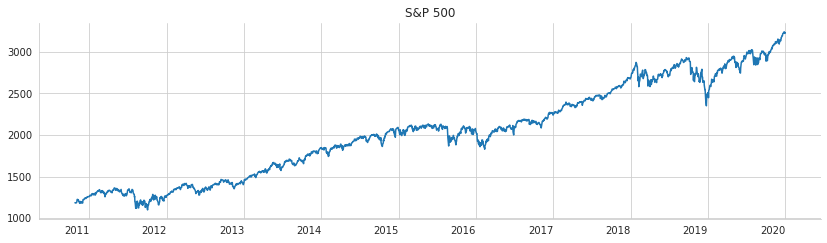

In [6]:
#We obtain data for 2010-2020 from the Federal Reserve Bank’s Data Service FRED using the pandas_datareader library
#https://fred.stlouisfed.org
sp500 = web.DataReader('SP500', 'fred', start='2010', end='2020').dropna()
ax = sp500.plot(title='S&P 500',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

In [7]:
#preprocessing
scaler = MinMaxScaler()

In [8]:
sp500_scaled = pd.Series(scaler.fit_transform(sp500).squeeze(), 
                         index=sp500.index)
sp500_scaled.describe()

count    2312.000000
mean        0.437952
std         0.259808
min         0.000000
25%         0.192848
50%         0.440244
75%         0.643877
max         1.000000
dtype: float64

In [9]:
#Generate recurrent sequences from time series
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [10]:
#Generate sequences of 63 trading days(three months)
window_size = 63

In [11]:
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

In [12]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
DATE,,,,,,,,,,,,,,,,,,,,,
2011-01-25,0.040354,0.040364,0.038873,0.039495,0.039252,0.039775,0.044068,0.046118,0.056909,0.059146,...,0.079653,0.081862,0.087225,0.086197,0.090625,0.091457,0.085338,0.084562,0.086006,0.089504
2011-01-26,0.040364,0.038873,0.039495,0.039252,0.039775,0.044068,0.046118,0.056909,0.059146,0.057932,...,0.081862,0.087225,0.086197,0.090625,0.091457,0.085338,0.084562,0.086006,0.089504,0.089663
2011-01-27,0.038873,0.039495,0.039252,0.039775,0.044068,0.046118,0.056909,0.059146,0.057932,0.053331,...,0.087225,0.086197,0.090625,0.091457,0.085338,0.084562,0.086006,0.089504,0.089663,0.092209
2011-01-28,0.039495,0.039252,0.039775,0.044068,0.046118,0.056909,0.059146,0.057932,0.053331,0.055811,...,0.086197,0.090625,0.091457,0.085338,0.084562,0.086006,0.089504,0.089663,0.092209,0.093568
2011-01-31,0.039252,0.039775,0.044068,0.046118,0.056909,0.059146,0.057932,0.053331,0.055811,0.053396,...,0.090625,0.091457,0.085338,0.084562,0.086006,0.089504,0.089663,0.092209,0.093568,0.082731


In [13]:
y.head()

DATE
2011-01-25    0.089663
2011-01-26    0.092209
2011-01-27    0.093568
2011-01-28    0.082731
2011-01-31    0.087300
dtype: float64

In [14]:
X.shape

(2249, 63)

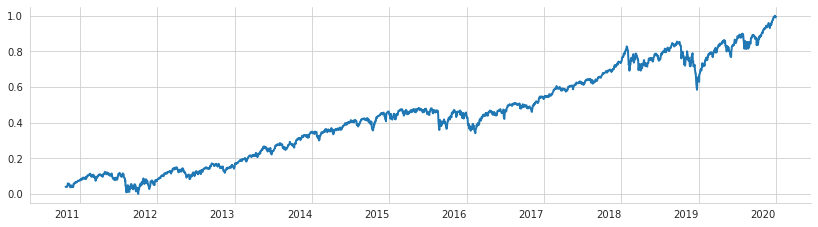

In [15]:
ax = sp500_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [17]:
X_train = X[:'2018'].values.reshape(-1, window_size, 1)
y_train = y[:'2018']

# keep the last year for testing
X_test = X['2019'].values.reshape(-1, window_size, 1)
y_test = y['2019']

In [18]:
n_obs, window_size, n_features = X_train.shape

In [19]:
y_train.shape

(1997,)

In [20]:
#resource:https://keras.io/api/layers/recurrent_layers/
#layer 1: LSTM with 20 hidden units, input_shape = (window_size,1)
#layer 2: fully connected module with one unit
rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

In [21]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 10)                480       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [22]:
#resource:https://keras.io/api/optimizers/
optimizer = keras.optimizers.RMSprop(lr=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

In [23]:
rnn.compile(loss='mean_squared_error', 
            optimizer=optimizer)

In [24]:
rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

In [25]:
#EarlyStopping callback and train the model for up to 100 episodes
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)

In [26]:
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)

Epoch 1/150
 97/100 [============================>.] - ETA: 0s - loss: 0.0151
Epoch 00001: val_loss improved from inf to 0.00249, saving model to results/univariate_time_series/rnn.h5
100/100 [==============================] - 2s 18ms/step - loss: 0.0147 - val_loss: 0.0025
Epoch 2/150
100/100 [==============================] - ETA: 0s - loss: 3.9464e-04
Epoch 00002: val_loss improved from 0.00249 to 0.00056, saving model to results/univariate_time_series/rnn.h5
100/100 [==============================] - 1s 13ms/step - loss: 3.9464e-04 - val_loss: 5.5767e-04
Epoch 3/150
100/100 [==============================] - ETA: 0s - loss: 3.5133e-04
Epoch 00003: val_loss improved from 0.00056 to 0.00034, saving model to results/univariate_time_series/rnn.h5
100/100 [==============================] - 1s 13ms/step - loss: 3.5133e-04 - val_loss: 3.3817e-04
Epoch 4/150
 99/100 [============================>.] - ETA: 0s - loss: 3.0628e-04
Epoch 00004: val_loss did not improve from 0.00034
100/100 [====

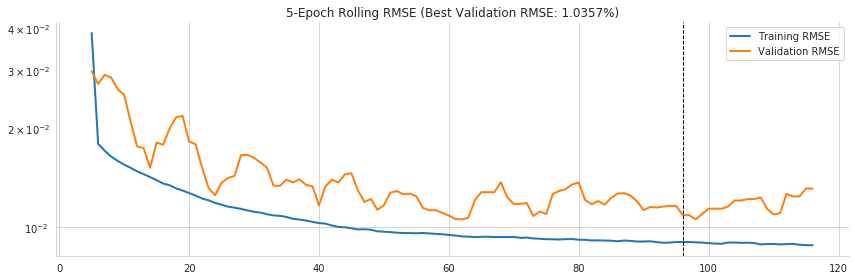

In [27]:
#Evaluate model performance
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300);

In [28]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0085 | Test RMSE: 0.0104


In [29]:
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9987 | Test IC: 0.9817


In [30]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
                          .squeeze(), 
                          index=y_test.index))

In [31]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [32]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 18.24 | Test RMSE: 22.17'

In [33]:
sp500['Train Predictions'] = train_predict
sp500['Test Predictions'] = test_predict
sp500 = sp500.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

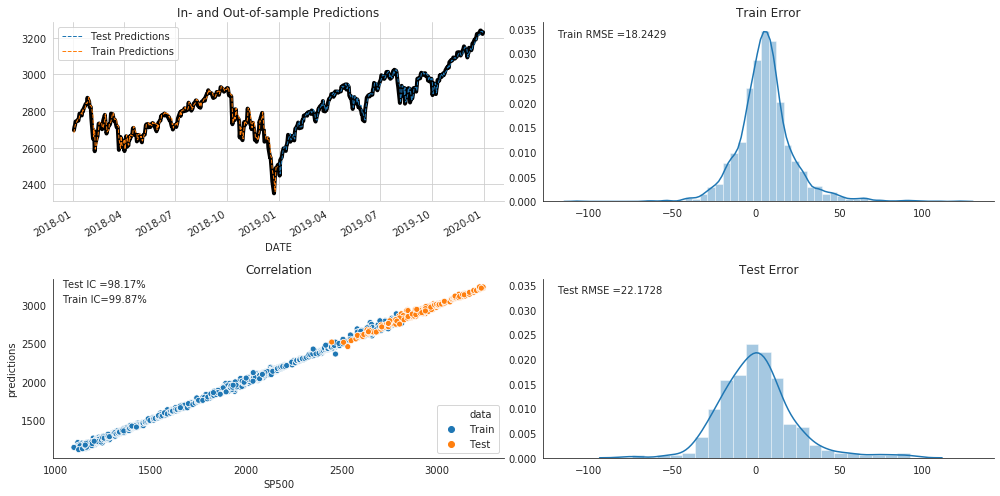

In [37]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

sp500.loc['2018':, 'SP500'].plot(lw=4, ax=ax1, c='k')
sp500.loc['2018':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='SP500', y='predictions', data=sp500, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_regression', dpi=300);